# DATA PREPROCESSING

## **Mục lục**

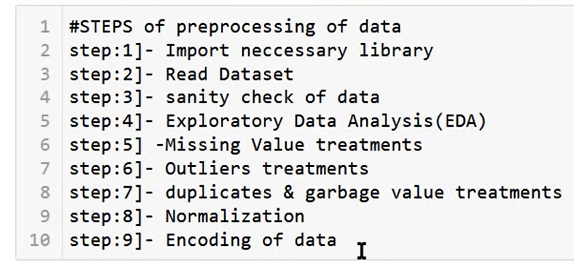

___
## 1. Chuẩn bị vấn đề

In [126]:
import pandas as pd
import os

In [127]:
customers = pd.read_csv("../data/1_raw/olist_customers_dataset.csv")
orders = pd.read_csv("../data/1_raw/olist_orders_dataset.csv")
order_items = pd.read_csv("../data/1_raw/olist_order_items_dataset.csv")
products = pd.read_csv("../data/1_raw/olist_products_dataset.csv")
sellers = pd.read_csv("../data/1_raw/olist_sellers_dataset.csv")
payments = pd.read_csv("../data/1_raw/olist_order_payments_dataset.csv")
reviews = pd.read_csv("../data/1_raw/olist_order_reviews_dataset.csv")
geolocation = pd.read_csv("../data/1_raw/olist_geolocation_dataset.csv")
product_category_translation = pd.read_csv("../data/1_raw/product_category_name_translation.csv")

___
## 2. Hàm tiền xử lý chung

In [128]:
def remove_duplicate(df):
    return df.drop_duplicates()

def drop_columns(df, cols):
    return df.drop(columns=[c for c in cols if c in df.columns])

def strip_columns(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].str.strip()
    return df

____
## 3. Hàm tiền xử lý riêng

### 3.1 Customer

In [129]:
def cleaning_customer(df):
    # Xử lý trùng
    df = remove_duplicate(df)

    # Bỏ cột không cần thiết
    # cols = ["customer_zip_code_prefix"]
    # df = drop_columns(df, cols)

    # Tạo mapping từ mã bang -> tên đầy đủ
    state_mapping = {
        "AC": "Acre",
        "AL": "Alagoas",
        "AP": "Amapá",
        "AM": "Amazonas",
        "BA": "Bahia",
        "CE": "Ceará",
        "DF": "Distrito Federal",
        "ES": "Espírito Santo",
        "GO": "Goiás",
        "MA": "Maranhão",
        "MT": "Mato Grosso",
        "MS": "Mato Grosso do Sul",
        "MG": "Minas Gerais",
        "PA": "Pará",
        "PB": "Paraíba",
        "PR": "Paraná",
        "PE": "Pernambuco",
        "PI": "Piauí",
        "RJ": "Rio de Janeiro",
        "RN": "Rio Grande do Norte",
        "RS": "Rio Grande do Sul",
        "RO": "Rondônia",
        "RR": "Roraima",
        "SC": "Santa Catarina",
        "SP": "São Paulo",
        "SE": "Sergipe",
        "TO": "Tocantins"
    }


    # Mapping mã bang -> vùng tiếng Anh
    region_mapping_en = {
        "AC": "North", "AP": "North", "AM": "North", "PA": "North", "RO": "North", "RR": "North", "TO": "North",
        "AL": "Northeast", "BA": "Northeast", "CE": "Northeast", "MA": "Northeast", "PB": "Northeast",
        "PE": "Northeast", "PI": "Northeast", "RN": "Northeast", "SE": "Northeast",
        "DF": "Central-West", "GO": "Central-West", "MT": "Central-West", "MS": "Central-West",
        "ES": "Southeast", "MG": "Southeast", "RJ": "Southeast", "SP": "Southeast",
        "PR": "South", "RS": "South", "SC": "South"
    }

    # Thêm cột tên bang đầy đủ
    df["state_name"] = df["customer_state"].map(state_mapping)
    df["region"] = df["customer_state"].map(region_mapping_en)

    return df

In [130]:
df = cleaning_customer(customers)

In [131]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,state_name,region
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,São Paulo,Southeast
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,São Paulo,Southeast
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,São Paulo,Southeast
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,São Paulo,Southeast
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,São Paulo,Southeast


### 3.2 Order

In [132]:
print(f"Xác thực đơn trước khi khách đặt: {[orders[(orders['order_approved_at'] < orders['order_purchase_timestamp'])].shape[0]]}")
print(f"Chuyển hàng cho đơn vị vận chuyển trước khi xác thực đơn từ khách: {[orders[(orders['order_delivered_carrier_date'] < orders['order_approved_at'])].shape[0]]}")
print(f"Giao cho khách trước khi đơn tới đơn vị vận chuyển: {[orders[(orders['order_delivered_customer_date'] < orders['order_delivered_carrier_date'])].shape[0]]}")

Xác thực đơn trước khi khách đặt: [0]
Chuyển hàng cho đơn vị vận chuyển trước khi xác thực đơn từ khách: [1359]
Giao cho khách trước khi đơn tới đơn vị vận chuyển: [23]


**Nhận xét:**
- Về cơ bản những chênh lệch này có thể lỗi do backend, nhưng không gây lỗi dữ liệu => vẫn sử dụng các bản ghi này.
- Đánh cờ các bản ghi lỗi logic

In [133]:
def cleaning_order(df):
    # Xử lý trùng
    df = remove_duplicate(df)

    # Xử lý thời gian
    timestamp_cols = ["order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date"]
    for col in timestamp_cols:
        df[col] = pd.to_datetime(df[col].astype(str), errors='coerce')

    # Thêm cột flag cho các bản ghi không hợp lý
    df['invalid_approve'] = (
        df['order_approved_at'].notna() & 
        df['order_purchase_timestamp'].notna() &
        (df['order_approved_at'] < df['order_purchase_timestamp'])
    )

    df['invalid_carrier'] = (
        df['order_delivered_carrier_date'].notna() &
        df['order_approved_at'].notna() &
        (df['order_delivered_carrier_date'] < df['order_approved_at'])
    )

    df['invalid_customer_delivery'] = (
        df['order_delivered_customer_date'].notna() &
        df['order_delivered_carrier_date'].notna() &
        (df['order_delivered_customer_date'] < df['order_delivered_carrier_date'])
    )

    return df

In [134]:
print(cleaning_order(orders)["invalid_approve"].value_counts())
print()
print(cleaning_order(orders)["invalid_carrier"].value_counts())
print()
print(cleaning_order(orders)["invalid_customer_delivery"].value_counts())

invalid_approve
False    99441
Name: count, dtype: int64

invalid_carrier
False    98082
True      1359
Name: count, dtype: int64

invalid_customer_delivery
False    99418
True        23
Name: count, dtype: int64


### 3.3 Order Item

In [135]:
def cleaning_order_item(df):
    # Xử lý trùng
    df = remove_duplicate(df)

    # # Bỏ cột không cần thiết
    # cols = ["seller_id", "shipping_limit_date"]
    # df = drop_columns(df, cols)

    return df

### 3.2 Payment

In [136]:
display(payments[(payments["payment_installments"] <= 0) | (payments["payment_installments"].isnull())])
display(payments[payments["order_id"] == "744bade1fcf9ff3f31d860ace076d422"].head())
display(payments[payments["order_id"] == "1a57108394169c0b47d8f876acc9ba2d"].head())

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69


,order_id,payment_sequential,payment_type,payment_installments,payment_value
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


**Nhận xét:**
- Có sự bất hợp lý của thứ tự thanh toán (payment_sequential) bắt đầu từ lần thứ 2 và đợt thanh toán (payment_installments) = 0
- Chỉ có 2 bản ghi không đáng kể => map "payment_installments" 0 -> 1

In [137]:
def cleaning_payment(df):
    # Xử lý trùng
    df = remove_duplicate(df)

    # Bỏ cột không cần thiết
    cols = ["payment_sequential"]
    df = drop_columns(df, cols)

    # map 2 bản ghi 0 -> 1
    df["payment_installments"] = df["payment_installments"].apply(lambda x: 1 if x <= 0 else x)

    return df

### 3.5 Review

In [138]:
print(reviews["review_score"].value_counts())

review_score
5    57328
4    19142
1    11424
3     8179
2     3151
Name: count, dtype: int64


In [139]:
def cleaning_review(df):
    # Xử lý trùng
    df = remove_duplicate(df)

    # Bỏ cột không cần thiết
    cols = ["review_comment_title", "review_creation_date", "review_answer_timestamp"]
    df = drop_columns(df, cols)

    return df

### 3.6 Product

In [140]:
def cleaning_product(products, product_category_translation):
    # Xử lý trùng
    df = remove_duplicate(products)

    # Chọn cột cần thiết
    cols = ["product_name_lenght","product_description_lenght","product_photos_qty"]
    df = drop_columns(df, cols=cols)

    # Join bảng dịch tên
    df = df.merge(product_category_translation, on='product_category_name', how='left')

    # Xóa cột sản phẩm ngôn ngữ gốc & đổi tên cột sản phẩm ngôn ngữ anh
    df = drop_columns(df, cols=["product_category_name"])
    df = df.rename(columns={"product_category_name_english": "product_category_name"})

    return df

In [141]:
print(cleaning_product(products, product_category_translation)["product_category_name"].value_counts())

product_category_name
bed_bath_table               3029
sports_leisure               2867
furniture_decor              2657
health_beauty                2444
housewares                   2335
                             ... 
tablets_printing_image          9
fashion_childrens_clothes       5
home_comfort_2                  5
security_and_services           2
cds_dvds_musicals               1
Name: count, Length: 71, dtype: int64


### 3.7 Seller

In [142]:
def cleaning_seller(df):
    # Xử lý trùng
    df = remove_duplicate(df)

    # Tạo mapping từ mã bang -> tên đầy đủ
    state_mapping = {
        "AC": "Acre",
        "AL": "Alagoas",
        "AP": "Amapá",
        "AM": "Amazonas",
        "BA": "Bahia",
        "CE": "Ceará",
        "DF": "Distrito Federal",
        "ES": "Espírito Santo",
        "GO": "Goiás",
        "MA": "Maranhão",
        "MT": "Mato Grosso",
        "MS": "Mato Grosso do Sul",
        "MG": "Minas Gerais",
        "PA": "Pará",
        "PB": "Paraíba",
        "PR": "Paraná",
        "PE": "Pernambuco",
        "PI": "Piauí",
        "RJ": "Rio de Janeiro",
        "RN": "Rio Grande do Norte",
        "RS": "Rio Grande do Sul",
        "RO": "Rondônia",
        "RR": "Roraima",
        "SC": "Santa Catarina",
        "SP": "São Paulo",
        "SE": "Sergipe",
        "TO": "Tocantins"
    }


    # Mapping mã bang -> vùng tiếng Anh
    region_mapping_en = {
        "AC": "North", "AP": "North", "AM": "North", "PA": "North", "RO": "North", "RR": "North", "TO": "North",
        "AL": "Northeast", "BA": "Northeast", "CE": "Northeast", "MA": "Northeast", "PB": "Northeast",
        "PE": "Northeast", "PI": "Northeast", "RN": "Northeast", "SE": "Northeast",
        "DF": "Central-West", "GO": "Central-West", "MT": "Central-West", "MS": "Central-West",
        "ES": "Southeast", "MG": "Southeast", "RJ": "Southeast", "SP": "Southeast",
        "PR": "South", "RS": "South", "SC": "South"
    }

    # Thêm cột tên bang đầy đủ
    df["state_name"] = df["seller_state"].map(state_mapping)
    df["region"] = df["seller_state"].map(region_mapping_en)

    return df

### 3.8 Geolocation

In [143]:
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [144]:
def cleaning_geolocation(df):
    # Xử lý trùng
    df = remove_duplicate(df)

    cols = ["geolocation_city", "geolocation_state"]
    df = drop_columns(df, cols)

    df = df.groupby(["geolocation_zip_code_prefix"]).agg({
        "geolocation_lat": "mean",
        "geolocation_lng": "mean"
    }).reset_index()

    df = df.rename(columns={
        "geolocation_lat": "lat",
        "geolocation_lng": "long"
    })
    return df


In [145]:
cleaning_geolocation(geolocation)

,geolocation_zip_code_prefix,lat,long
0,1001,-23.550227,-46.634039
1,1002,-23.547657,-46.634991
2,1003,-23.549000,-46.635582
3,1004,-23.549829,-46.634792
4,1005,-23.549547,-46.636406
...,...,...,...
19010,99960,-27.953722,-52.025511
19011,99965,-28.183372,-52.039850
19012,99970,-28.343920,-51.874988
19013,99980,-28.389500,-51.843122


____
## 4. Thực thi xử lý

In [146]:
customers = cleaning_customer(customers)
orders = cleaning_order(orders)
order_items = cleaning_order_item(order_items)
payments = cleaning_payment(payments)
reviews = cleaning_review(reviews)
products = cleaning_product(products, product_category_translation)
sellers = cleaning_seller(sellers)
geolocation = cleaning_geolocation(geolocation)

In [147]:
# Lưu từng DataFrame
output_dir = "../data/2_clean"

customers.to_csv(os.path.join(output_dir, "customers.csv"), index=False)
orders.to_csv(os.path.join(output_dir, "orders.csv"), index=False)
order_items.to_csv(os.path.join(output_dir, "order_items.csv"), index=False)
payments.to_csv(os.path.join(output_dir, "payments.csv"), index=False)
reviews.to_csv(os.path.join(output_dir, "reviews.csv"), index=False)
products.to_csv(os.path.join(output_dir, "products.csv"), index=False)
sellers.to_csv(os.path.join(output_dir, "sellers.csv"), index=False)
geolocation.to_csv(os.path.join(output_dir, "geolocation.csv"), index=False)